In [1]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import os
import pyranges as pr
import gseapy as gp
from gseapy import barplot, dotplot
import json

In [2]:
cell_type = 'CD8'
de_type = 'include_emergent_disappear' # include_emergent_disappear, no_emergent_include_disappear, no_emergent_no_disappear
fig_path = '/home/che/TRIM/git/tcr/figures/saliency'
parent_path = f'{fig_path}/{de_type}/{cell_type}/data'
geneset_path = f'{parent_path}/gene_sets'
csv_path = f'{parent_path}/diffexp_df.csv'
output_path = f'{parent_path}/compiled'
venn_path = f'{output_path}/venn/all_gradient'

if not os.path.exists(output_path):
    os.makedirs(output_path)
if not os.path.exists(venn_path):
    os.makedirs(venn_path)

print(output_path)
print(venn_path)

/home/che/TRIM/git/tcr/figures/saliency/include_emergent_disappear/CD8/data/compiled
/home/che/TRIM/git/tcr/figures/saliency/include_emergent_disappear/CD8/data/compiled/venn/all_gradient


In [3]:
# read in the whole gene list
with open('/home/che/TRIM/data_processed/combined_data_columns.npz', 'rb') as f:
    npzfile = np.load(f, allow_pickle=True)
    combined_data_columns = npzfile['cols']
complete_gene_list = combined_data_columns.tolist()
len(complete_gene_list)

29750

In [4]:
# Read in the whole dataset
df = pd.read_csv(csv_path)
df.rename(columns={'Unnamed: 0': 'Gene'}, inplace=True)
df

,Gene,lfc_post,lfc_pre,lfc_clone_pre_10,lfc_clone_pre_1,lfc_post_pvals_adj,lfc_pre_pvals_adj,lfc_clone_pre_10_pvals_adj,lfc_clone_pre_1_pvals_adj,salient_genes,salient_genes_rank,lfc_post_rank,lfc_pre_rank,lfc_clone_pre_10_rank,lfc_clone_pre_1_rank
0,A1BG,0.841133,-0.794820,-0.725561,-1.166667,9.641343e-08,0.00015,1.121982e-12,2.611040e-41,-0.000007,10791.0,1865.0,17173.0,16486.0,17158.0
1,A1BG-AS1,0.630395,-0.090250,-0.484623,0.291439,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,0.000031,2010.0,2357.0,13270.0,15601.0,6076.0
2,A2M,-1.642448,2.252429,-0.178504,-0.586164,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,0.000051,658.0,18341.0,454.0,13850.0,13951.0
3,A2M-AS1,0.501576,0.178894,0.893563,0.957310,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,-0.000027,15070.0,2735.0,8739.0,3887.0,2239.0
4,A4GALT,-1.497684,2.251524,0.973174,-0.587068,NaN,NaN,NaN,NaN,0.000005,6178.0,17228.0,1452.5,2731.5,14951.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19251,ZXDC,0.052903,-0.004820,0.134014,-0.018931,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,0.000010,5125.0,6347.0,11984.0,9515.0,10352.0
19252,ZYG11A,-1.497684,0.396684,2.828014,1.267772,NaN,1.00000,1.000000e+00,1.000000e+00,-0.000029,15255.0,17228.0,6003.0,359.0,1522.0
19253,ZYG11B,0.317693,-0.155747,-0.495282,-0.672724,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,-0.000004,10006.0,3636.0,14064.0,15651.0,16224.0
19254,ZYX,-0.018861,-0.026237,0.016083,0.089319,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,-0.000028,15111.0,7555.0,12323.0,11443.0,8987.0


### Step 1. Get the genes that each method picks up

In [5]:
# first subset to the genes found by different methods
if de_type == 'no_emergent_no_disappear':
    alpha = 0.05
    log2fc_threshold = -np.inf
    high_gradient_threshold = 0.996
    low_gradient_threshold = 1- high_gradient_threshold #0.01
else:
    alpha = 0.01
    log2fc_threshold = -np.inf
    high_gradient_threshold = 0.99
    low_gradient_threshold = 1- high_gradient_threshold #0.01

top_genes_lfc_post = df[df['lfc_post_pvals_adj'] < alpha].copy()
top_genes_lfc_post = top_genes_lfc_post[abs(top_genes_lfc_post['lfc_post']) > log2fc_threshold]
df['top_genes_lfc_post'] = df['Gene'].isin(top_genes_lfc_post['Gene'])
print('len top_genes_lfc_post', len(top_genes_lfc_post))

top_genes_lfc_pre = df[df['lfc_pre_pvals_adj'] < alpha].copy()
top_genes_lfc_pre = top_genes_lfc_pre[abs(top_genes_lfc_pre['lfc_pre']) > log2fc_threshold]
df['top_genes_lfc_pre'] = df['Gene'].isin(top_genes_lfc_pre['Gene'])
print('len top_genes_lfc_pre', len(top_genes_lfc_pre))

top_genes_grad = df[(df['salient_genes'] > df['salient_genes'].quantile(high_gradient_threshold)) | 
                    (df['salient_genes'] < df['salient_genes'].quantile(low_gradient_threshold))]
df['top_genes_grad'] = df['Gene'].isin(top_genes_grad['Gene'])
print('len top_genes_grad:', len(top_genes_grad))

top_genes_lfc_clone_pre_1 = df[df['lfc_clone_pre_1_pvals_adj'] < alpha]
top_genes_lfc_clone_pre_1 = top_genes_lfc_clone_pre_1[abs(top_genes_lfc_clone_pre_1['lfc_clone_pre_1']) > log2fc_threshold]
df['top_genes_lfc_clone_pre_1'] = df['Gene'].isin(top_genes_lfc_clone_pre_1['Gene'])
print('len top_genes_lfc_clone_pre_1', len(top_genes_lfc_clone_pre_1))

top_genes_lfc_clone_pre_10 = df[df['lfc_clone_pre_10_pvals_adj'] < alpha]
top_genes_lfc_clone_pre_10 = top_genes_lfc_clone_pre_10[abs(top_genes_lfc_clone_pre_10['lfc_clone_pre_10']) > log2fc_threshold]
df['top_genes_lfc_clone_pre_10'] = df['Gene'].isin(top_genes_lfc_clone_pre_10['Gene'])
print('len top_genes_lfc_clone_pre_10', len(top_genes_lfc_clone_pre_10))

df_subset = df[df['Gene'].isin(top_genes_lfc_post['Gene']) | 
                df['Gene'].isin(top_genes_lfc_pre['Gene']) |
               df['Gene'].isin(top_genes_grad['Gene']) | 
               df['Gene'].isin(top_genes_lfc_clone_pre_10['Gene']) | 
               df['Gene'].isin(top_genes_lfc_clone_pre_1['Gene'])].copy()
df_subset

len top_genes_lfc_post 432
len top_genes_lfc_pre 466
len top_genes_grad: 386
len top_genes_lfc_clone_pre_1 1519
len top_genes_lfc_clone_pre_10 888


,Gene,lfc_post,lfc_pre,lfc_clone_pre_10,lfc_clone_pre_1,lfc_post_pvals_adj,lfc_pre_pvals_adj,lfc_clone_pre_10_pvals_adj,lfc_clone_pre_1_pvals_adj,salient_genes,salient_genes_rank,lfc_post_rank,lfc_pre_rank,lfc_clone_pre_10_rank,lfc_clone_pre_1_rank,top_genes_lfc_post,top_genes_lfc_pre,top_genes_grad,top_genes_lfc_clone_pre_1,top_genes_lfc_clone_pre_10
0,A1BG,0.841133,-0.794820,-0.725561,-1.166667,9.641343e-08,1.504766e-04,1.121982e-12,2.611040e-41,-0.000007,10791.0,1865.0,17173.0,16486.0,17158.0,True,True,False,True,True
37,ABCB9,-0.504494,-1.068248,-0.942749,-1.228584,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-0.000089,19153.0,14188.0,17735.0,17094.0,17257.0,False,False,True,False,False
45,ABCD2,0.612471,-0.986414,-0.716174,-0.660411,1.000000e+00,1.000000e+00,1.000000e+00,5.904538e-03,-0.000063,18558.0,2407.0,17579.0,16456.0,16187.0,False,False,False,True,False
64,ABHD17A,-0.496471,0.581175,0.784946,1.030809,2.574536e-03,9.659899e-08,3.985006e-25,1.507854e-35,0.000059,393.0,14141.0,4818.0,4126.0,2057.0,True,True,False,True,True
76,ABI3,-0.405581,0.551165,0.528436,1.170311,6.399717e-02,5.022182e-05,3.270137e-07,3.755932e-33,-0.000041,16932.0,13530.0,4982.0,5072.0,1738.0,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19162,ZNF814,0.311633,-1.714411,-1.153668,-1.398973,1.000000e+00,1.000000e+00,1.000000e+00,1.870137e-05,-0.000070,18788.0,3671.0,18472.0,17487.0,17462.0,False,False,False,True,False
19199,ZNHIT1,-0.080221,0.239010,0.256901,0.390924,1.000000e+00,1.000000e+00,1.000000e+00,6.796115e-03,0.000015,4331.0,8756.0,7871.0,7497.0,4917.0,False,False,False,True,False
19215,ZRANB2-AS1,-1.497684,4.351961,-1.127263,-2.687505,NaN,1.000000e+00,1.000000e+00,1.000000e+00,0.000075,158.0,17228.0,51.0,17451.0,18660.0,False,False,True,False,False
19222,ZSCAN18,0.466925,-0.539419,-1.463122,-1.888522,1.000000e+00,1.000000e+00,2.669569e-05,3.251631e-18,0.000020,3514.0,2869.0,16469.0,17919.0,17843.0,False,False,False,True,True


### Step 2. Focus on protein coding genes

In [6]:
# read in gencode file
protein_gene_path = '/home/che/TRIM/git/tcr/other_information/gencode.v41.annotation.gtf'
gr = pr.read_gtf(protein_gene_path)
gencode_df = gr.df
gencode_df = gencode_df[gencode_df['Feature'] == 'gene']
gencode_df = gencode_df[gencode_df['gene_type'] == 'protein_coding']
protein_coding_genes = gencode_df['gene_name'].unique().tolist()
print('len protein_coding_genes:', len(protein_coding_genes))

len protein_coding_genes: 19991


In [7]:
# protein coding genes downloaded from: https://www.genenames.org/download/statistics-and-files/
protein_gene_path = '/home/che/TRIM/git/tcr/other_information/gene_with_protein_product.txt'
protein_genes = pd.read_csv(protein_gene_path, sep='\t')
protein_genes_2 = protein_genes['symbol'].unique().tolist()
print('len protein_genes_2:', len(protein_genes_2))
len(set(protein_coding_genes) - set(protein_genes_2))

len protein_genes_2: 19268


/tmp/ipykernel_790134/2460345661.py:3: DtypeWarning: Columns (35,38,45,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_genes = pd.read_csv(protein_gene_path, sep='\t')


987

In [8]:
# Subset to human protein-coding genes
df_subset = df_subset[df_subset['Gene'].isin(protein_coding_genes)]
df_subset

,Gene,lfc_post,lfc_pre,lfc_clone_pre_10,lfc_clone_pre_1,lfc_post_pvals_adj,lfc_pre_pvals_adj,lfc_clone_pre_10_pvals_adj,lfc_clone_pre_1_pvals_adj,salient_genes,salient_genes_rank,lfc_post_rank,lfc_pre_rank,lfc_clone_pre_10_rank,lfc_clone_pre_1_rank,top_genes_lfc_post,top_genes_lfc_pre,top_genes_grad,top_genes_lfc_clone_pre_1,top_genes_lfc_clone_pre_10
0,A1BG,0.841133,-0.794820,-0.725561,-1.166667,9.641343e-08,1.504766e-04,1.121982e-12,2.611040e-41,-0.000007,10791.0,1865.0,17173.0,16486.0,17158.0,True,True,False,True,True
37,ABCB9,-0.504494,-1.068248,-0.942749,-1.228584,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-0.000089,19153.0,14188.0,17735.0,17094.0,17257.0,False,False,True,False,False
45,ABCD2,0.612471,-0.986414,-0.716174,-0.660411,1.000000e+00,1.000000e+00,1.000000e+00,5.904538e-03,-0.000063,18558.0,2407.0,17579.0,16456.0,16187.0,False,False,False,True,False
64,ABHD17A,-0.496471,0.581175,0.784946,1.030809,2.574536e-03,9.659899e-08,3.985006e-25,1.507854e-35,0.000059,393.0,14141.0,4818.0,4126.0,2057.0,True,True,False,True,True
76,ABI3,-0.405581,0.551165,0.528436,1.170311,6.399717e-02,5.022182e-05,3.270137e-07,3.755932e-33,-0.000041,16932.0,13530.0,4982.0,5072.0,1738.0,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19134,ZNF776,0.372331,-1.575151,-1.176315,-1.623787,1.000000e+00,1.000000e+00,1.000000e+00,2.243293e-03,-0.000053,18020.0,3317.0,18361.0,17529.0,17655.0,False,False,False,True,False
19162,ZNF814,0.311633,-1.714411,-1.153668,-1.398973,1.000000e+00,1.000000e+00,1.000000e+00,1.870137e-05,-0.000070,18788.0,3671.0,18472.0,17487.0,17462.0,False,False,False,True,False
19199,ZNHIT1,-0.080221,0.239010,0.256901,0.390924,1.000000e+00,1.000000e+00,1.000000e+00,6.796115e-03,0.000015,4331.0,8756.0,7871.0,7497.0,4917.0,False,False,False,True,False
19222,ZSCAN18,0.466925,-0.539419,-1.463122,-1.888522,1.000000e+00,1.000000e+00,2.669569e-05,3.251631e-18,0.000020,3514.0,2869.0,16469.0,17919.0,17843.0,False,False,False,True,True


In [9]:
# save df_subset to the csv
df_subset.to_csv(f'{output_path}/diffexp_df_subset_protein_coding.csv', index=False)
print('saved to:', f'{output_path}/diffexp_df_subset_protein_coding.csv')

saved to: /home/che/TRIM/git/tcr/figures/saliency/include_emergent_disappear/CD8/data/compiled/diffexp_df_subset_protein_coding.csv


### Step 3. Draw the venn diagram (pulled)

In [10]:
top_genes_lfc_post = set(df_subset[df_subset['top_genes_lfc_post'] == True]['Gene'].tolist())
top_genes_lfc_pre = set(df_subset[df_subset['top_genes_lfc_pre'] == True]['Gene'].tolist())
top_genes_grad = set(df_subset[df_subset['top_genes_grad'] == True]['Gene'].tolist())
top_genes_lfc_clone_pre_10 = set(df_subset[df_subset['top_genes_lfc_clone_pre_10'] == True]['Gene'].tolist())
top_genes_lfc_clone_pre_1 = set(df_subset[df_subset['top_genes_lfc_clone_pre_1'] == True]['Gene'].tolist())

len(top_genes_lfc_post), len(top_genes_lfc_pre), \
        len(top_genes_lfc_clone_pre_10), len(top_genes_lfc_clone_pre_1), \
                len(top_genes_grad)

(401, 431, 808, 1408, 219)

In [11]:
selected_columns = ['Gene', 'salient_genes', 'top_genes_grad',
                    'lfc_post', 'lfc_post_pvals_adj',
                    'lfc_pre', 'lfc_pre_pvals_adj',
                    'lfc_clone_pre_10', 'lfc_clone_pre_10_pvals_adj',
                    'lfc_clone_pre_1', 'lfc_clone_pre_1_pvals_adj']

In [12]:
df_clean = df_subset[selected_columns].copy()
df_clean.to_csv(f'{output_path}/diffexp_df_protein_coding_cleaned.csv', index=False)

In [13]:
df_clean[(df_clean['lfc_post_pvals_adj'] < alpha) & (abs(df_clean['lfc_post']) > log2fc_threshold)].shape[0],\
    df_clean[(df_clean['lfc_pre_pvals_adj'] < alpha) & (abs(df_clean['lfc_pre']) > log2fc_threshold)].shape[0],\
        df_clean[(df_clean['lfc_clone_pre_10_pvals_adj'] < alpha) & (abs(df_clean['lfc_clone_pre_10']) > log2fc_threshold)].shape[0],\
            df_clean[(df_clean['lfc_clone_pre_1_pvals_adj'] < alpha) & (abs(df_clean['lfc_clone_pre_1']) > log2fc_threshold)].shape[0],\
                df_clean[df_clean['top_genes_grad'] == 1].shape[0]

(401, 431, 808, 1408, 219)

### Generate Venn diagram for gradients (positive+negative)

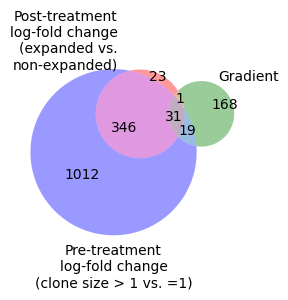

In [14]:
plt.figure(figsize=(3, 3))
venn = venn3(
    subsets=[
        top_genes_lfc_post,
        top_genes_grad,
        top_genes_lfc_clone_pre_1,
    ],
    set_labels=("Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)", 
                "Gradient", 
                "Pre-treatment\nlog-fold change\n(clone size > 1 vs. =1)"),
)
for label in venn.set_labels:
    if label:
        label.set_fontsize(10)  # Adjust font size for set labels
plt.tight_layout()
plt.savefig(f'{venn_path}/venn_lfc_post_grad_lfc_clone_pre_1_pulled.png', dpi=300)
plt.savefig(f'{venn_path}/venn_lfc_post_grad_lfc_clone_pre_1_pulled.svg', format='svg')
plt.show()

In [15]:
# top_genes_lfc_post&top_genes_grad, 
# top_genes_lfc_clone_pre_1&top_genes_grad, 
# top_genes_lfc_post&top_genes_lfc_clone_pre_1&top_genes_grad

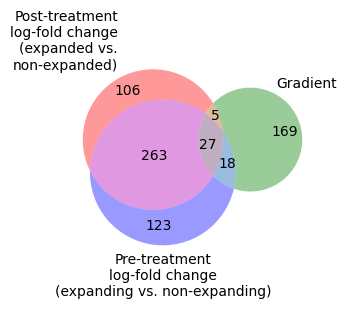

In [16]:
plt.figure(figsize=(3.5, 3.5))
venn = venn3(
    subsets=[
        top_genes_lfc_post,
        top_genes_grad,
        top_genes_lfc_pre,
    ],
    set_labels=("Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)", 
                "Gradient", 
                "Pre-treatment\nlog-fold change\n(expanding vs. non-expanding)"),
)
for label in venn.set_labels:
    if label:
        label.set_fontsize(10)  # Adjust font size for set labels
plt.tight_layout()
plt.savefig(f'{venn_path}/venn_lfc_post_grad_lfc_pre.png', dpi=300)
plt.savefig(f'{venn_path}/venn_lfc_post_grad_lfc_pre.svg', format='svg')
plt.show()

In [17]:
top_genes_lfc_post&top_genes_lfc_pre&top_genes_grad

{'ADRB2',
 'CCL5',
 'CCR7',
 'CMC1',
 'CST7',
 'CTSC',
 'EFHD2',
 'FGR',
 'GNLY',
 'GZMA',
 'GZMH',
 'HCST',
 'HOPX',
 'IFITM2',
 'IL6R',
 'KLRD1',
 'KLRG1',
 'NKG7',
 'PASK',
 'PRF1',
 'PTPRCAP',
 'RHOC',
 'RPS8',
 'RPS9',
 'S100A4',
 'SESN3',
 'SH3BGRL3'}

In [18]:
top_genes_lfc_post&(top_genes_grad-top_genes_lfc_pre) #,top_genes_lfc_pre&(top_genes_grad-top_genes_lfc_post)

{'CENPU', 'IL32', 'RPS2', 'RPS27', 'RPS4X'}

In [19]:
'CD2' in top_genes_grad, 'CD2' in top_genes_lfc_post, 'CD2' in top_genes_lfc_pre

(True, False, True)

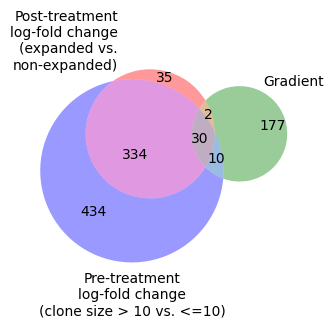

In [20]:
plt.figure(figsize=(3.5, 3.5))
venn = venn3(
    subsets=[
        top_genes_lfc_post,
        top_genes_grad,
        top_genes_lfc_clone_pre_10,
    ],
    set_labels=("Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)", 
                "Gradient", 
                "Pre-treatment\nlog-fold change\n(clone size > 10 vs. <=10)"),
)
for label in venn.set_labels:
    if label:
        label.set_fontsize(10)  # Adjust font size for set labels
plt.tight_layout()
plt.savefig(f'{venn_path}/venn_lfc_post_grad_lfc_clone_pre_10_pulled.png', dpi=300)
plt.savefig(f'{venn_path}/venn_lfc_post_grad_lfc_clone_pre_10_pulled.svg', format='svg')
plt.show()

In [21]:
top_genes_lfc_post&top_genes_lfc_clone_pre_10&top_genes_grad

{'ADRB2',
 'CCL5',
 'CCR7',
 'CMC1',
 'CST7',
 'CTSC',
 'EFHD2',
 'FGR',
 'GNLY',
 'GZMA',
 'GZMH',
 'HCST',
 'HOPX',
 'IFITM2',
 'IL6R',
 'KLRD1',
 'KLRG1',
 'NKG7',
 'PASK',
 'PRF1',
 'PTPRCAP',
 'RHOC',
 'RPS2',
 'RPS27',
 'RPS4X',
 'RPS8',
 'RPS9',
 'S100A4',
 'SESN3',
 'SH3BGRL3'}

In [22]:
top_genes_lfc_post&(top_genes_grad - top_genes_lfc_clone_pre_10) #, top_genes_lfc_clone_pre_10&(top_genes_grad-top_genes_lfc_post)

{'CENPU', 'IL32'}

### ChatGPT scorings

1. Send ChatGPT the pulled list of *important genes* found by different methods
<!-- 1. Send ChatGPT all protein-coding genes after QC in the data -->
2. Ask ChatGPT to provide lists of genes that are relevant/predictive of T-cell expansion (as well as their associated biological process)
3. Plot a heatmap to show the ‘hit rate’ of different methods and compute the p-value of hypergeometric test

In [23]:
all_genes = top_genes_lfc_post| top_genes_grad| top_genes_lfc_clone_pre_1 | top_genes_lfc_pre | top_genes_lfc_clone_pre_10
all_genes = set(all_genes)
# all_genes

In [24]:
# save all all_genes into config file
with open(f'{venn_path}/top_genes_lfc_pre.txt', 'w') as f:
    for item in top_genes_lfc_pre:
        f.write("%s\n" % item)

with open(f'{venn_path}/top_genes_grad.txt', 'w') as f:
    for item in top_genes_grad:
        f.write("%s\n" % item)

with open(f'{venn_path}/top_genes_lfc_post.txt', 'w') as f:
    for item in top_genes_lfc_post:
        f.write("%s\n" % item)


with open(f'{venn_path}/top_genes_lfc_clone_pre_1.txt', 'w') as f:
    for item in top_genes_lfc_clone_pre_1:
        f.write("%s\n" % item)

with open(f'{venn_path}/top_genes_lfc_clone_pre_10.txt', 'w') as f:
    for item in top_genes_lfc_clone_pre_10:
        f.write("%s\n" % item)

# save all all_genes into config file
with open(f'{venn_path}/all_genes.txt', 'w') as f:
    for item in all_genes:
        f.write("%s\n" % item)

In [25]:
len(all_genes)

1628

In [26]:
# load in relevant genes and whole go dictionary (in json format)
with open(f"{geneset_path}/relevant_genes.json", "r") as f:
    relevant_genes = json.load(f)

with open(f"{geneset_path}/go_enrichr.json", "r") as f:
    go_terms = json.load(f)

In [27]:
# remove genes from relevant_genes if they are not in all_genes
for key in relevant_genes:
    relevant_genes[key] = [gene for gene in relevant_genes[key] if gene in all_genes]

Explanation of Categories:
1. T-cell activation and immune response: Genes critical for initiating and sustaining T-cell activation and immune-related processes.
2. T-cell proliferation and cell cycle regulation: Genes that regulate T-cell division and cell cycle checkpoints during expansion.
3. Cytotoxic and effector functions: Genes that facilitate cytotoxic killing and effector molecule release.
4. Regulation of immune pathways: Genes modulating pathways to balance immune activation and suppression.
5. Metabolism and signaling pathways: Genes involved in metabolic reprogramming and intracellular signaling during activation.
6. Cytoskeletal dynamics and migration: Genes regulating structural changes and migration of T-cells.
7. Immune checkpoint molecules and regulation: Genes encoding immune checkpoint proteins and other modulators of immune responses.

#### Run hypergeometric test to check enrichment

In [28]:
from scipy.stats import hypergeom
# get all genes in relevant_genes dict as a set
relevant_genes_set = set()
for key in relevant_genes:
    relevant_genes_set.update(relevant_genes[key])

# all_genes = set(all_protein_genes)
print('len relevant_genes_set:', len(relevant_genes_set))
print('len all_genes:', len(all_genes))
print(len(relevant_genes_set - all_genes))
print(relevant_genes_set - all_genes)

len relevant_genes_set: 130
len all_genes: 1628
0
set()


In [29]:
test_methods = ['lfc_post', 'grad', 'lfc_clone_pre_1', 'lfc_pre', 'lfc_clone_pre_10']
test_genes = [top_genes_lfc_post, top_genes_grad, top_genes_lfc_clone_pre_1, top_genes_lfc_pre, top_genes_lfc_clone_pre_10]
p_vals_dict = {}

for i in range(len(test_methods)):
    print(test_methods[i])
    test_genes_temp = test_genes[i]
    print(f'len test_genes_temp: {len(test_genes_temp)}')
    relevant_genes_set = relevant_genes_set & all_genes
    assert relevant_genes_set - all_genes == set(), f'Not all relevant genes are in all_genes (background list)'
    # calculate p-values of the hypergeometric test for each method
    N = len(all_genes)  # Total number of genes in the background
    K = len(relevant_genes_set)   # Number of genes in the target set
    n = len(test_genes_temp)          # Number of genes in my list
    k = len(relevant_genes_set & test_genes_temp)  # Overlap between filtered gene set and my list
    print(f'Background genes: {N}, Relevant genes: {K}, Genes in my list: {n}, Overlap: {k}')
    p_value = hypergeom.sf(k - 1, N, K, n)
    p_vals_dict[test_methods[i]] = p_value
    print(f'p-value: {p_value}')

lfc_post
len test_genes_temp: 401
Background genes: 1628, Relevant genes: 130, Genes in my list: 401, Overlap: 71
p-value: 1.6617074298828708e-14
grad
len test_genes_temp: 219
Background genes: 1628, Relevant genes: 130, Genes in my list: 219, Overlap: 44
p-value: 3.4001531348308434e-10
lfc_clone_pre_1
len test_genes_temp: 1408
Background genes: 1628, Relevant genes: 130, Genes in my list: 1408, Overlap: 101
p-value: 0.9986490178658926
lfc_pre
len test_genes_temp: 431
Background genes: 1628, Relevant genes: 130, Genes in my list: 431, Overlap: 76
p-value: 8.227971755275106e-16
lfc_clone_pre_10
len test_genes_temp: 808
Background genes: 1628, Relevant genes: 130, Genes in my list: 808, Overlap: 86
p-value: 5.590550018603753e-05


#### Draw heatmap

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the dictionary and annotate keys
flattened_genes = []
categories = []
for category, genes in relevant_genes.items():
    flattened_genes.extend(genes)
    categories.extend([category] * len(genes))

flattened_genes_go = []
categories_go = []
for category, genes in go_terms.items():
    flattened_genes_go.extend(genes)
    categories_go.extend([category] * len(genes))

len(flattened_genes), len(categories), len(flattened_genes_go), len(categories_go)

(148, 148, 10043, 10043)

In [31]:
# Gene presence in top lists
heatmap_data = {
    f"Gradient\np={p_vals_dict['grad']:.3f}": [1 if gene in top_genes_grad else 0 for gene in flattened_genes],
    f"Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)\np={p_vals_dict['lfc_post']:.3f}": [1 if gene in top_genes_lfc_post else 0 for gene in flattened_genes],
    f"Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)\np={p_vals_dict['lfc_pre']:.3f}": [1 if gene in top_genes_lfc_pre else 0 for gene in flattened_genes],
    f"Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)\np={p_vals_dict['lfc_clone_pre_1']:.3f}": [1 if gene in top_genes_lfc_clone_pre_1 else 0 for gene in flattened_genes],
    f"Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)\np={p_vals_dict['lfc_clone_pre_10']:.3f}": [1 if gene in top_genes_lfc_clone_pre_10 else 0 for gene in flattened_genes],
}

# Create a DataFrame for visualization
df = pd.DataFrame(heatmap_data, index=flattened_genes)
df['category'] = categories

# Plot the heatmap
# plt.figure(figsize=(15, 12))
# sns.heatmap(df.iloc[:, :-1], annot=False, cmap='Blues', cbar=True, linewidths=0.5)

# # Annotate category labels on the y-axis
# plt.yticks(
#     ticks=range(len(flattened_genes)),
#     labels=[f"{gene} ({category})" for gene, category in zip(flattened_genes, categories)],
#     fontsize=10
# )
# plt.ylabel('Genes (Biological process)')
# plt.tight_layout()
# plt.savefig(f'{output_path}/heatmap_relevant_genes.png', dpi=300)
# plt.savefig(f'{output_path}/heatmap_relevant_genes.svg', format='svg')
# plt.show()

In [32]:
# remove \np=... from the column names
df.columns = df.columns.str.replace(r'\np=.*', '', regex=True)

In [33]:
df.sum(axis=0)

Gradient                                                                                                         54
Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)                                                    79
Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)                                                   87
Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)                                                        113
Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)                                                      98
category                                                          t_cell_activation_and_immune_responset_cell_ac...
dtype: object

In [34]:
# Define columns
columns = [
    'Gradient',
    'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)',
    'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)',
    'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)',
    'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)'
]

# Initialize p-value dataframe
df_pvals = pd.DataFrame(index=relevant_genes.keys(), columns=columns)

# Make sure all gene sets are sets
all_genes = set(all_genes)
top_genes_dict = {
    'Gradient': set(top_genes_grad),
    'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)': set(top_genes_lfc_post),
    'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)': set(top_genes_lfc_pre),
    'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)': set(top_genes_lfc_clone_pre_1),
    'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)': set(top_genes_lfc_clone_pre_10)
}

# Loop through categories and methods
for category in df_pvals.index:
    gene_set_temp = set(relevant_genes[category])
    print(gene_set_temp - all_genes)
    # assert gene_set_temp <= all_genes, f'Some genes in {category} are not in the background gene list'
    K = len(gene_set_temp)  # Relevant genes in category
    N = len(all_genes)  # Total genes in background
    
    for method in df_pvals.columns:
        gene_list_temp = top_genes_dict[method]
        n = len(gene_list_temp)
        k = len(gene_set_temp & gene_list_temp)
        
        # Hypergeometric test
        p_value = hypergeom.sf(k - 1, N, K, n)
        df_pvals.loc[category, method] = p_value

# For each method, correct p-values using Benjamini-Hochberg method
from statsmodels.stats.multitest import multipletests

for method in df_pvals.columns:
    pvals = df_pvals[method].astype(float)
    _, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    df_pvals[method] = pvals_corrected

# turn p-values into -log10(p-values)
df_pvals = -np.log10(df_pvals.astype(float))
df_pvals

set()
set()
set()
set()
set()
set()
set()


,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)
t_cell_activation_and_immune_response,3.322719,3.052163,3.118158,0.000482,0.546143
t_cell_proliferation_and_cell_cycle_regulation,0.969871,1.311977,0.858705,0.000482,0.415664
cytotoxic_and_effector_functions,2.364560,5.788667,7.934796,0.296260,2.409098
regulation_of_immune_pathways,1.433988,1.787904,1.966503,0.000482,1.266137
metabolism_and_signaling_pathways,2.356004,1.787904,1.737440,0.000482,0.546143
cytoskeletal_dynamics_and_migration,2.305180,1.068132,2.232798,0.000482,0.546143
immune_checkpoint_molecules_and_regulation,1.115834,0.825865,1.648888,0.000482,0.546143


In [35]:
-np.log10(0.05)

1.3010299956639813

In [36]:
# calculate sum for each column grouped by category and plot the heatmap
df_sum = df.groupby('category').sum()

# order by the order of df['category'].unique().tolist()
df_sum = df_sum.reindex(df['category'].unique().tolist())

assert df_sum.index.tolist() == df_pvals.index.tolist(), 'Indices do not match'
assert df_sum.columns.tolist() == df_pvals.columns.tolist(), 'Columns do not match'

df_sum

,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)
category,,,,,
t_cell_activation_and_immune_response,15,20,21,30,22
t_cell_proliferation_and_cell_cycle_regulation,4,7,6,8,8
cytotoxic_and_effector_functions,8,15,17,18,16
regulation_of_immune_pathways,8,15,16,23,22
metabolism_and_signaling_pathways,8,10,10,14,12
cytoskeletal_dynamics_and_migration,7,7,10,10,10
immune_checkpoint_molecules_and_regulation,4,5,7,10,8


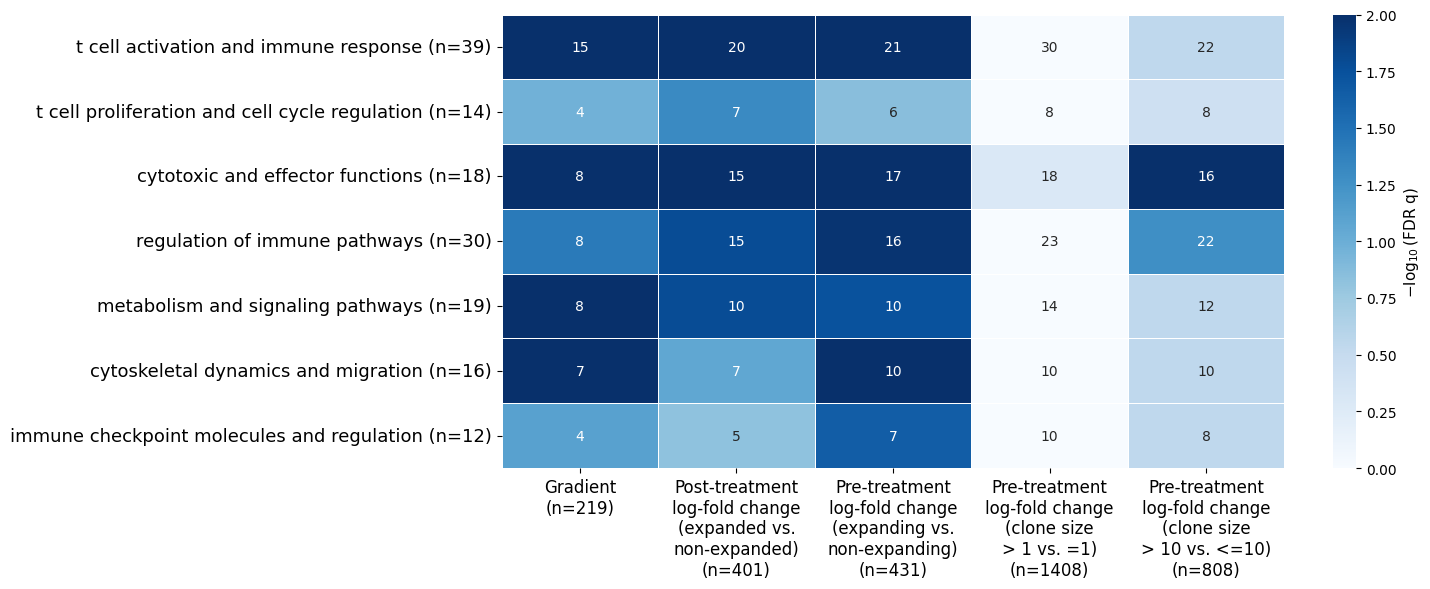

In [37]:
df_color = df_pvals.copy()

# append total number of genes in each category to the y-axis labels
index_new = []
for index in df_color.index:
    n_temp = len(relevant_genes[index])
    index_new.append(f'{index} (n={n_temp})')
df_color.index = index_new
df_color.index = df_color.index.str.replace('_', ' ') # rename y-axis labels (remove _)

# append total number of genes in each column to the x-axis labels
col_num = []
for column in df_color.columns:
    if column == 'Gradient':
        n_temp = len(top_genes_grad)
    elif column == 'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)':
        n_temp = len(top_genes_lfc_post)
    elif column == 'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)':
        n_temp = len(top_genes_lfc_pre)
    elif column == 'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)':
        n_temp = len(top_genes_lfc_clone_pre_1)
    elif column == 'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)':
        n_temp = len(top_genes_lfc_clone_pre_10)
    col_num.append(f'{column}\n(n={n_temp})')
df_color.columns = col_num

# Plot the heatmap
plt.figure(figsize=(15, 6))
# ax = sns.heatmap(df_color, annot=df_sum, cmap='RdBu_r', cbar=True, linewidths=0.5, vmin=0, center=-np.log10(0.05), vmax=-np.log10(0.001))
ax = sns.heatmap(df_color, annot=df_sum, cmap='Blues', cbar=True, linewidths=0.5, vmin=0, vmax=-np.log10(0.01))
# change the xticks font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)

# Change colorbar label font size
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r'$-\log_{10}$(FDR q)', fontsize=11)

plt.ylabel('')
plt.tight_layout()
plt.savefig(f'{output_path}/heatmap_relevant_genes_sum.png', dpi=300)
plt.savefig(f'{output_path}/heatmap_relevant_genes_sum.svg', format='svg')
plt.show()

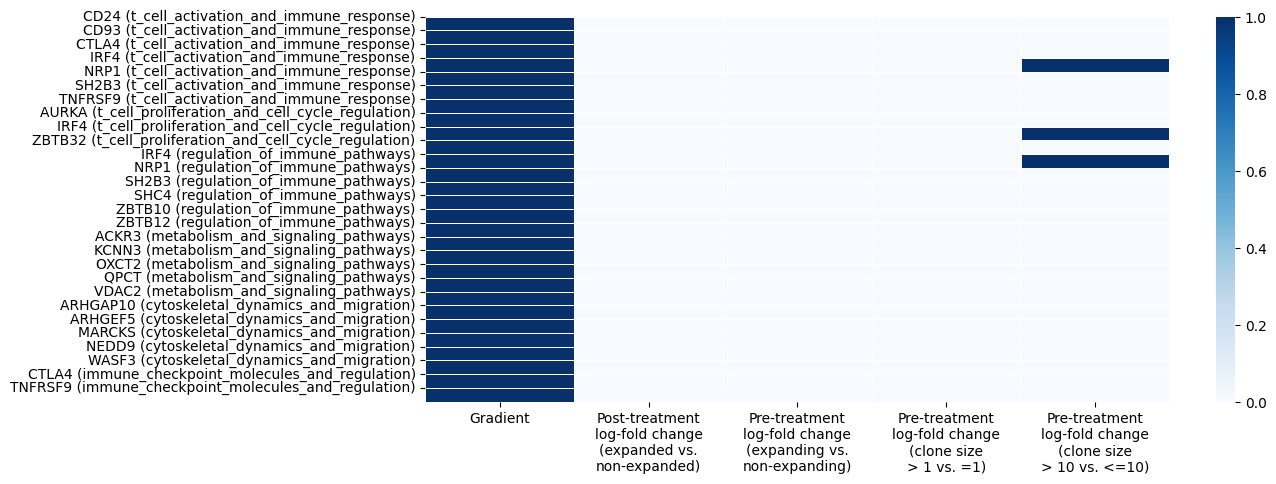

In [38]:
# give me genes that only have 1 in the gradient and 0 in the rest
df_temp = df[(df['Gradient'] == 1) & (df['Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)'] == 0)
              & (df['Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)'] == 0) 
              & (df['Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)'] == 0) 
              & (df['Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)'] == 0)]

# plot the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(df_temp.iloc[:, :-1], annot=False, cmap='Blues', cbar=True, linewidths=0.5)
# annotate category labels on the y-axis
plt.yticks(
    ticks=range(len(df_temp)),
    labels=[f"{gene} ({category})" for gene, category in zip(df_temp.index, df_temp['category'])],
    fontsize=10
)
plt.show()

### General pathway (GO terms), run hypergeometric test manually

In [39]:
# Define columns
columns = [
    'Gradient',
    'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)',
    'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)',
    'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)',
    'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)'
]

# Initialize p-value dataframe
df_pvals_go = pd.DataFrame(index=go_terms.keys(), columns=columns)

# Make sure all gene sets are sets
top_genes_dict = {
    'Gradient': set(top_genes_grad),
    'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)': set(top_genes_lfc_post),
    'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)': set(top_genes_lfc_pre),
    'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)': set(top_genes_lfc_clone_pre_1),
    'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)': set(top_genes_lfc_clone_pre_10)
}

# Loop through categories and methods
for category in df_pvals_go.index:
    gene_set_temp = set(go_terms[category])

    K = len(gene_set_temp)       # Relevant genes in category
    N = len(set(complete_gene_list))  # Total genes in background

    for method in df_pvals_go.columns:
        gene_list_temp = top_genes_dict[method]
        n = len(gene_list_temp)
        k = len(gene_set_temp & gene_list_temp)

        # Hypergeometric test
        p_value = hypergeom.sf(k - 1, N, K, n)
        df_pvals_go.loc[category, method] = p_value

# For each method, correct p-values using Benjamini-Hochberg method
for method in df_pvals_go.columns:
    pvals = df_pvals_go[method].astype(float)
    _, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    df_pvals_go[method] = pvals_corrected

# turn p-values into -log10(p-values)
df_pvals_go = -np.log10(df_pvals_go.astype(float))
df_pvals_go

,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)
positive regulation of cell proliferation (GO:0008284),2.441813,11.532387,8.134552,11.117083,10.101209
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",4.125857,88.816531,78.696348,78.245170,79.009557
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),4.055929,93.942869,85.191944,91.477486,90.475570
positive regulation of peptidyl-tyrosine phosphorylation (GO:0050731),2.369374,2.868136,1.496840,1.617233,1.362150
platelet degranulation (GO:0002576),0.175571,10.548159,7.292853,9.703843,7.957773
T cell receptor signaling pathway (GO:0050852),0.120363,5.468417,5.932806,24.672775,12.047967
T cell activation (GO:0042110),1.349608,5.383127,8.012649,15.167169,7.690496
ribosomal small subunit biogenesis (GO:0042274),0.445705,10.549864,8.908147,7.956345,8.646389
regulation of apoptotic process (GO:0042981),1.213770,10.605120,10.802653,20.955074,14.954989
regulation of small GTPase mediated signal transduction (GO:0051056),2.472746,0.522888,1.238008,3.849814,1.756658


In [40]:
# Gene presence in top lists
heatmap_data_all = {
    f"Gradient": [1 if gene in top_genes_grad else 0 for gene in flattened_genes_go],
    f"Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)": [1 if gene in top_genes_lfc_post else 0 for gene in flattened_genes_go],
    f"Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)": [1 if gene in top_genes_lfc_pre else 0 for gene in flattened_genes_go],
    f"Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)": [1 if gene in top_genes_lfc_clone_pre_1 else 0 for gene in flattened_genes_go],
    f"Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)": [1 if gene in top_genes_lfc_clone_pre_10 else 0 for gene in flattened_genes_go],
}

# Create a DataFrame for visualization
df_all = pd.DataFrame(heatmap_data_all, index=flattened_genes_go)
df_all['category'] = categories_go
df_all.head()

,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10),category
EGF,0,0,0,0,0,positive regulation of cell proliferation (GO:...
LACRT,0,0,0,0,0,positive regulation of cell proliferation (GO:...
BAD,0,0,0,0,0,positive regulation of cell proliferation (GO:...
MCTS1,0,0,0,0,0,positive regulation of cell proliferation (GO:...
RPL23,0,0,0,1,0,positive regulation of cell proliferation (GO:...


In [41]:
# calculate sum for each column grouped by category and plot the heatmap
df_sum_go = df_all.groupby('category').sum()
df_sum_go = df_sum_go.reindex(df_all['category'].unique().tolist())

assert df_sum_go.index.tolist() == df_pvals_go.index.tolist(), 'Indices do not match'
assert df_sum_go.columns.tolist() == df_pvals_go.columns.tolist(), 'Columns do not match'

df_sum_go

,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)
category,,,,,
positive regulation of cell proliferation (GO:0008284),10,29,25,56,39
"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)",8,64,60,80,70
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),7,62,59,79,70
positive regulation of peptidyl-tyrosine phosphorylation (GO:0050731),5,7,5,11,7
platelet degranulation (GO:0002576),1,16,13,26,18
T cell receptor signaling pathway (GO:0050852),1,12,13,49,26
T cell activation (GO:0042110),3,9,12,28,15
ribosomal small subunit biogenesis (GO:0042274),1,11,10,14,12
regulation of apoptotic process (GO:0042981),11,39,41,108,68


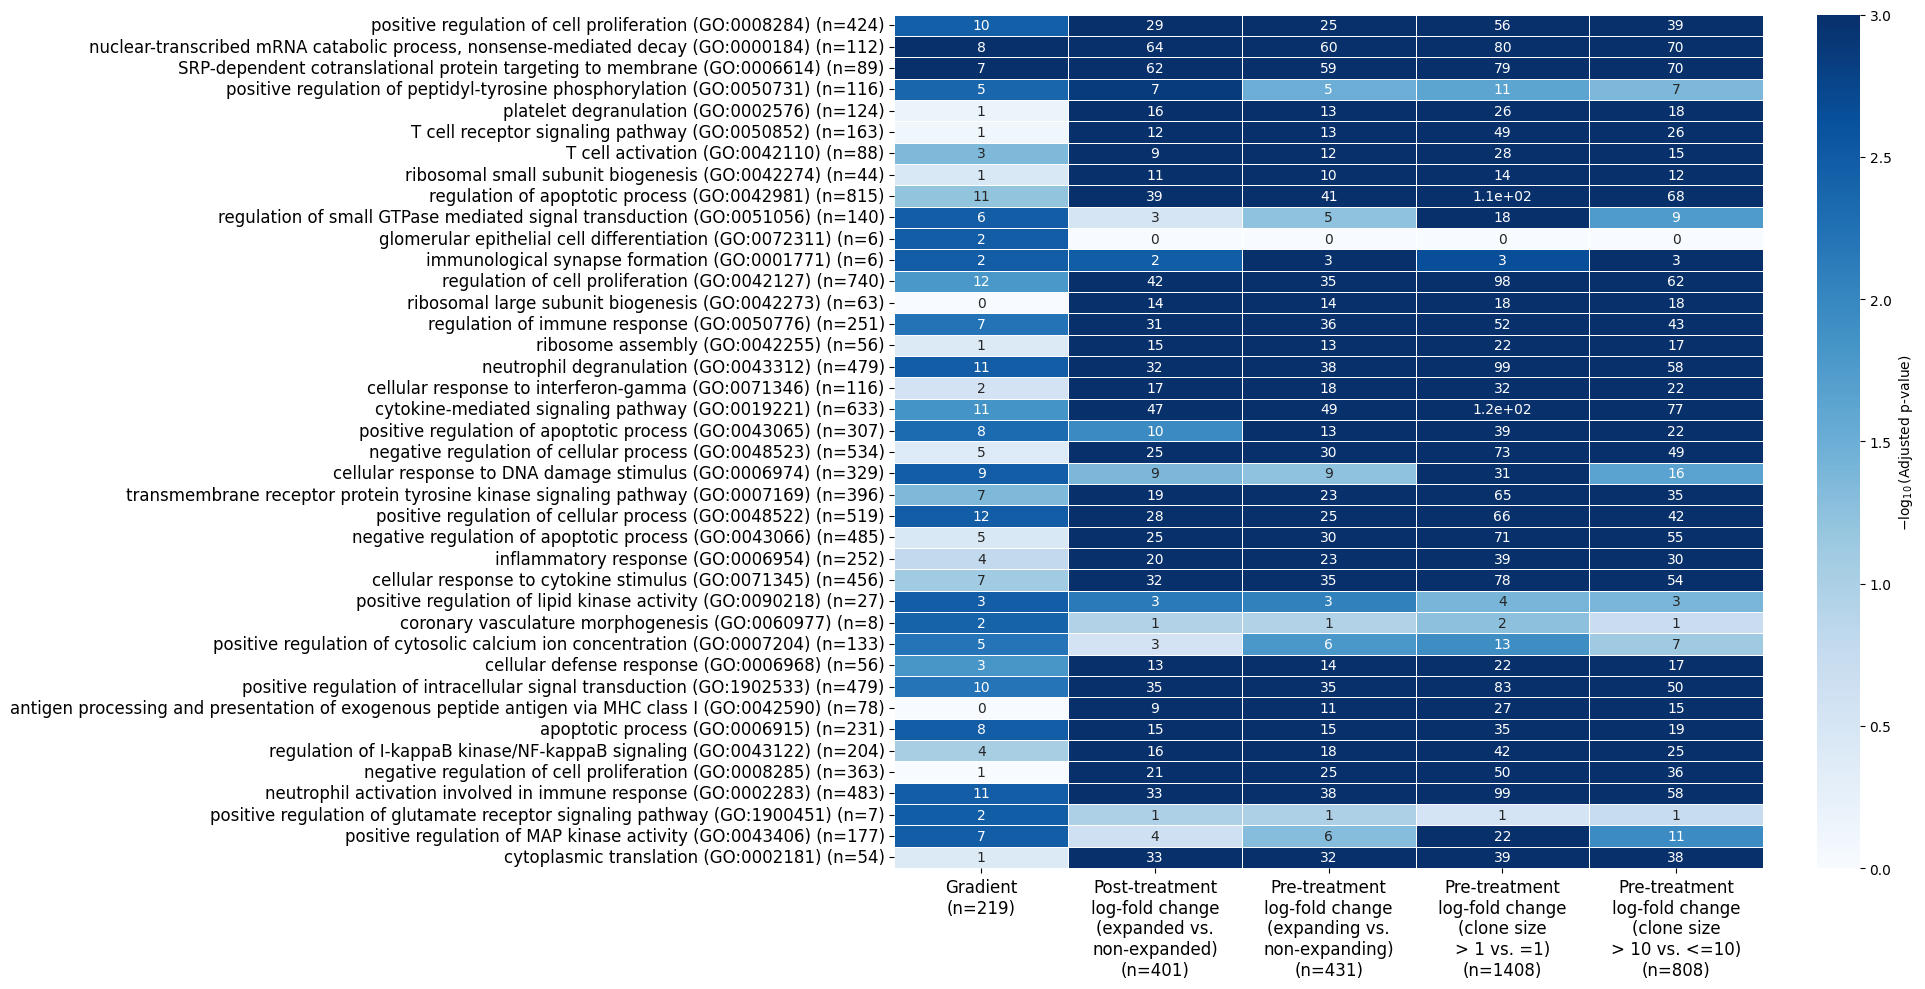

In [42]:
df_color_go = df_pvals_go.copy()

# append total number of genes in each category to the y-axis labels
index_new = []
for index in df_color_go.index:
    n_temp = len(go_terms[index])
    index_new.append(f'{index} (n={n_temp})')
df_color_go.index = index_new
df_color_go.index = df_color_go.index.str.replace('_', ' ') # rename y-axis labels (remove _)

# append total number of genes in each column to the x-axis labels
col_num = []
for column in df_color_go.columns:
    if column == 'Gradient':
        n_temp = len(top_genes_grad)
    elif column == 'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)':
        n_temp = len(top_genes_lfc_post)
    elif column == 'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)':
        n_temp = len(top_genes_lfc_pre)
    elif column == 'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)':
        n_temp = len(top_genes_lfc_clone_pre_1)
    elif column == 'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)':
        n_temp = len(top_genes_lfc_clone_pre_10)
    col_num.append(f'{column}\n(n={n_temp})')
df_color_go.columns = col_num

# Plot the heatmap
plt.figure(figsize=(20, 10))
# ax = sns.heatmap(df_color_go, annot=df_sum_go, cmap='RdBu_r', cbar=True, linewidths=0.5, vmin = 0, center=-np.log10(0.05), vmax = -np.log10(0.001), cbar_kws={'label': r'$-\log_{10}$(p-value)'})
ax = sns.heatmap(df_color_go, annot=df_sum_go, cmap='Blues', cbar=True, linewidths=0.5, vmin = 0, vmax = -np.log10(0.001))
# change the xticks font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Change colorbar label font size
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r'$-\log_{10}$(Adjusted p-value)', fontsize=10)

plt.ylabel('')
plt.tight_layout()
plt.savefig(f'{output_path}/heatmap_all_genes_go.png', dpi=300)
plt.savefig(f'{output_path}/heatmap_all_genes_go.svg', format='svg')
plt.show()

### General pathway (GO terms), report adjusted p-value from gp.enrichr

In [43]:
go_terms.keys()
# first read in all the enrichment.df 
methods_name = ['top_genes_grad', 'top_genes_lfc_post', 'top_genes_lfc_pre', 'top_genes_lfc_clone_pre_1', 'top_genes_lfc_clone_pre_10']
methods_name_clean = ['Gradient', 'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)', \
    'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)',
    'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)',
    'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)']

go_enrichr_all_df = pd.DataFrame()

for i in range(len(methods_name)):
    method = methods_name[i]
    method_clean = methods_name_clean[i] 
    path_temp = f'{geneset_path}/{method}_enrichment.csv'
    go_df_temp = pd.read_csv(path_temp)
    go_df_temp['Method'] = method_clean
    go_enrichr_all_df = pd.concat([go_enrichr_all_df, go_df_temp], axis=0)

go_enrichr_all_df = go_enrichr_all_df[go_enrichr_all_df['Term'].isin(go_terms.keys())]
go_enrichr_all_df

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,Method
0,GO_Biological_Process_2018,"nuclear-transcribed mRNA catabolic process, no...",0.000002,0.002576,0,0,10.728035,141.493170,RPS4X;RPS9;RPS27;RPS8;RPS29;RPS2;RPS4Y1;SMG6,Gradient
1,GO_Biological_Process_2018,SRP-dependent cotranslational protein targetin...,0.000004,0.002684,0,0,11.858203,146.270094,RPS4X;RPS9;RPS27;RPS8;RPS29;RPS2;RPS4Y1,Gradient
9,GO_Biological_Process_2018,apoptotic process (GO:0006915),0.000287,0.039489,0,0,5.098135,41.584460,CD2;GZMA;TNFRSF9;PRF1;LTA;CIDEB;ZNF385A;GZMH,Gradient
10,GO_Biological_Process_2018,positive regulation of MAP kinase activity (GO...,0.000319,0.039990,0,0,5.805785,46.730104,CD81;PEA15;CD24;TPD52L1;DRD4;TGFBR1;ARHGEF5,Gradient
11,GO_Biological_Process_2018,positive regulation of cellular process (GO:00...,0.000362,0.041588,0,0,3.450107,27.334180,RPS4X;USP47;RPS9;PDF;TSLP;CD81;DOT1L;RTKN2;CID...,Gradient
...,...,...,...,...,...,...,...,...,...,...
1080,GO_Biological_Process_2018,positive regulation of peptidyl-tyrosine phosp...,0.033258,0.098419,0,0,2.400083,8.168623,LYN;CD74;TGFB1;SEMA4D;CCL5;IL6ST;IL6R,Pre-treatment\nlog-fold change\n(clone size\n>...
1116,GO_Biological_Process_2018,positive regulation of lipid kinase activity (...,0.035982,0.102864,0,0,4.490373,14.929348,FGR;TGFB1;CCR7,Pre-treatment\nlog-fold change\n(clone size\n>...
1257,GO_Biological_Process_2018,positive regulation of cytosolic calcium ion c...,0.054555,0.138728,0,0,2.134705,6.208903,CD52;GPR65;F2R;PROK2;CCR7;SELENOT;PTGDR,Pre-treatment\nlog-fold change\n(clone size\n>...
1851,GO_Biological_Process_2018,positive regulation of glutamate receptor sign...,0.175325,0.300728,0,0,5.976043,10.404959,ADRB2,Pre-treatment\nlog-fold change\n(clone size\n>...


In [44]:
go_enrichr_p_val_df = go_enrichr_all_df.pivot_table(index='Term', columns='Method', values='Adjusted P-value', fill_value=1)
go_enrichr_p_val_df = -np.log10(go_enrichr_p_val_df.astype(float))
go_enrichr_p_val_df

Method,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)
Term,,,,,
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),2.571172,92.162435,89.502250,88.581929,83.398987
T cell activation (GO:0042110),0.668584,4.515020,15.195214,6.914487,7.125826
T cell receptor signaling pathway (GO:0050852),0.156390,4.305029,24.035070,10.840016,4.727915
antigen processing and presentation of exogenous peptide antigen via MHC class I (GO:0042590),-0.000000,4.558250,14.341043,6.989675,6.162193
apoptotic process (GO:0006915),1.403519,4.750362,7.525572,3.462358,4.423989
cellular defense response (GO:0006968),0.866633,10.991948,13.600965,11.858516,11.949468
cellular response to DNA damage stimulus (GO:0006974),1.248216,0.994892,2.755063,1.191579,0.900202
cellular response to cytokine stimulus (GO:0071345),0.634785,11.925217,21.351396,17.643029,13.411214
cellular response to interferon-gamma (GO:0071346),0.517409,10.818069,14.087573,10.542348,11.372392


In [45]:
go_enrichr_all_df['Gene_Count'] = go_enrichr_all_df['Genes'].apply(lambda x: len(x.split(';')))

# Create pivot table with Methods as columns, Terms as rows, and gene counts as values
go_enrichr_gene_count_df = go_enrichr_all_df.pivot_table(
    index='Term', 
    columns='Method', 
    values='Gene_Count',
    fill_value=0  # Fill missing combinations with 0
)

go_enrichr_gene_count_df

Method,Gradient,Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded),Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1),Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10),Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)
Term,,,,,
SRP-dependent cotranslational protein targeting to membrane (GO:0006614),7.0,62.0,79.0,70.0,59.0
T cell activation (GO:0042110),3.0,9.0,28.0,15.0,12.0
T cell receptor signaling pathway (GO:0050852),1.0,12.0,49.0,26.0,13.0
antigen processing and presentation of exogenous peptide antigen via MHC class I (GO:0042590),0.0,9.0,27.0,15.0,11.0
apoptotic process (GO:0006915),8.0,15.0,35.0,19.0,15.0
cellular defense response (GO:0006968),3.0,13.0,22.0,17.0,14.0
cellular response to DNA damage stimulus (GO:0006974),9.0,9.0,31.0,16.0,9.0
cellular response to cytokine stimulus (GO:0071345),7.0,32.0,78.0,54.0,35.0
cellular response to interferon-gamma (GO:0071346),2.0,17.0,32.0,22.0,18.0


In [46]:
# reindex go_enrichr_gene_count_df to match df_sum_go
go_enrichr_gene_count_df = go_enrichr_gene_count_df.reindex(df_sum_go.index.tolist())
go_enrichr_p_val_df = go_enrichr_p_val_df.reindex(df_sum_go.index.tolist())

# reorder columns to match df_sum_go
go_enrichr_gene_count_df = go_enrichr_gene_count_df.reindex(columns=df_sum_go.columns.tolist())
go_enrichr_p_val_df = go_enrichr_p_val_df.reindex(columns=df_sum_go.columns.tolist())

assert go_enrichr_gene_count_df.index.tolist() == go_enrichr_p_val_df.index.tolist(), 'Indices do not match'
assert go_enrichr_gene_count_df.columns.tolist() == go_enrichr_p_val_df.columns.tolist(), 'Columns do not match'

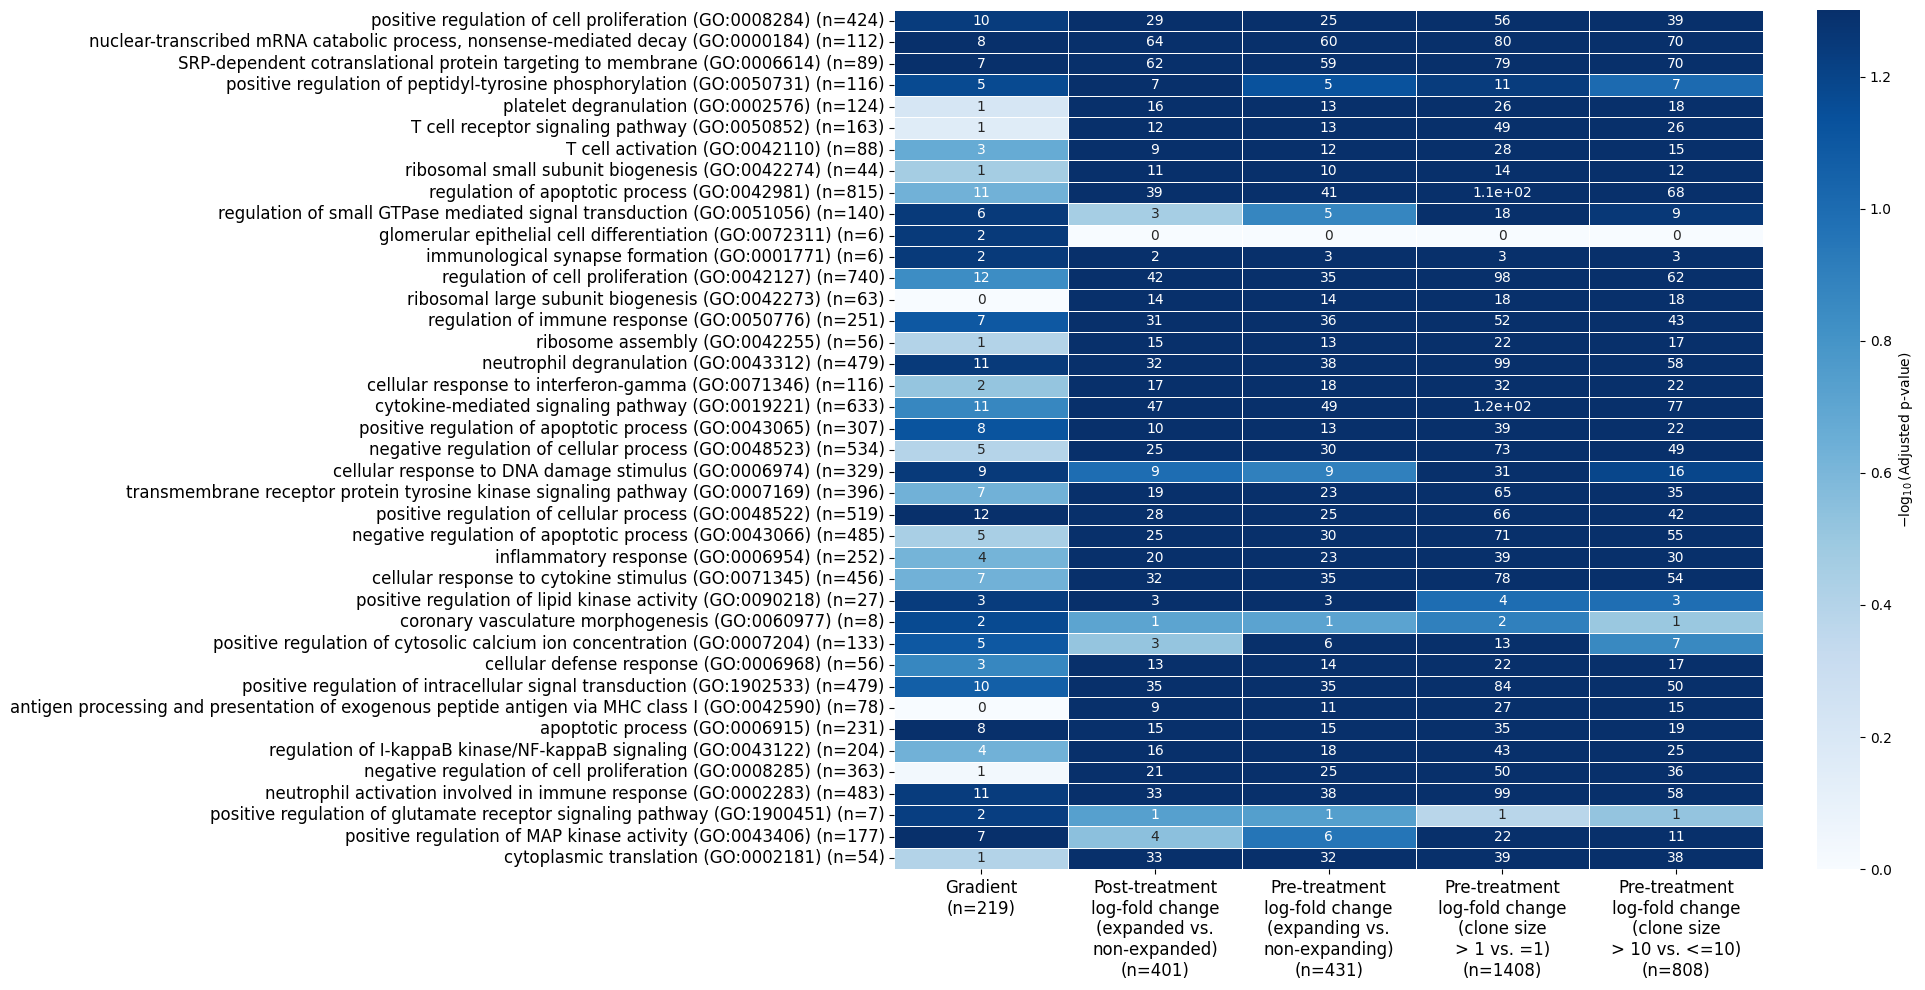

In [47]:
df_color_enrich_go = go_enrichr_p_val_df.copy()

# append total number of genes in each category to the y-axis labels
index_new = []
for index in df_color_enrich_go.index:
    n_temp = len(go_terms[index])
    index_new.append(f'{index} (n={n_temp})')
df_color_enrich_go.index = index_new
df_color_enrich_go.index = df_color_enrich_go.index.str.replace('_', ' ') # rename y-axis labels (remove _)

# append total number of genes in each column to the x-axis labels
col_num = []
for column in df_color_enrich_go.columns:
    if column == 'Gradient':
        n_temp = len(top_genes_grad)
    elif column == 'Post-treatment\nlog-fold change\n(expanded vs.\nnon-expanded)':
        n_temp = len(top_genes_lfc_post)
    elif column == 'Pre-treatment\nlog-fold change\n(expanding vs.\nnon-expanding)':
        n_temp = len(top_genes_lfc_pre)
    elif column == 'Pre-treatment\nlog-fold change\n(clone size\n> 1 vs. =1)':
        n_temp = len(top_genes_lfc_clone_pre_1)
    elif column == 'Pre-treatment\nlog-fold change\n(clone size\n> 10 vs. <=10)':
        n_temp = len(top_genes_lfc_clone_pre_10)
    col_num.append(f'{column}\n(n={n_temp})')
df_color_enrich_go.columns = col_num

# Plot the heatmap
plt.figure(figsize=(20, 10))
# ax = sns.heatmap(df_color_enrich_go, annot=go_enrichr_gene_count_df, cmap='RdBu_r', cbar=True, linewidths=0.5, vmin=0, center=-np.log10(0.05), vmax=-np.log10(0.001))
ax = sns.heatmap(df_color_enrich_go, annot=go_enrichr_gene_count_df, cmap='Blues', cbar=True, linewidths=0.5, vmin=0, vmax=-np.log10(0.05))
# change the xticks font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Change colorbar label font size
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r'$-\log_{10}$(Adjusted p-value)', fontsize=10)

plt.ylabel('')
plt.tight_layout()
plt.savefig(f'{output_path}/heatmap_all_genes_go_enrichr.png', dpi=300)
plt.savefig(f'{output_path}/heatmap_all_genes_go_enrichr.svg', format='svg')
plt.show()